In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/Capstone/dataset.zip' -d '/content/drive/MyDrive/Capstone/Dataset'

Archive:  /content/drive/MyDrive/Capstone/dataset.zip
  inflating: /content/drive/MyDrive/Capstone/Dataset/classname.txt  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train.csv  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.1.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.10.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.100.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.101.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.102.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.103.jpg  
  inflating: /content/drive/MyDrive/Caps

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

In [6]:
TRAIN_DIR = "/content/drive/MyDrive/Capstone/Dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/Capstone/Dataset/val"

BATCH_SIZE = 32
IMAGE_SIZE =(224,224)
EPOCHS = 100

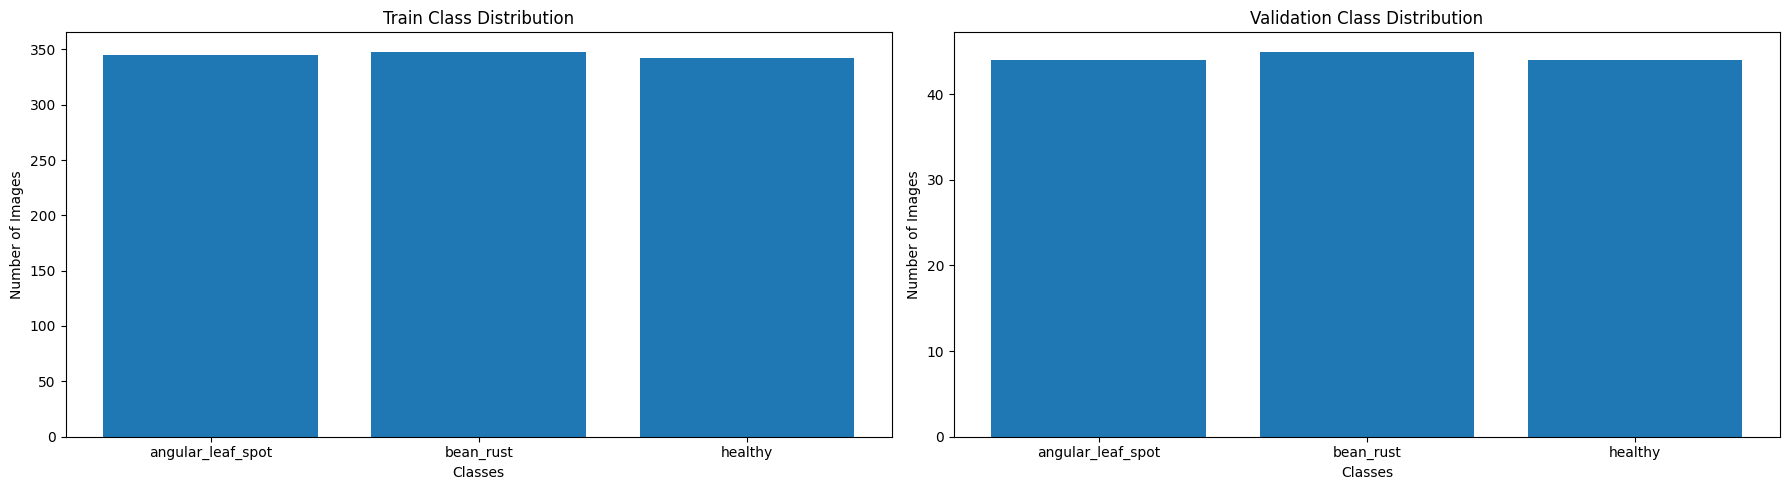

In [7]:
import os
import matplotlib.pyplot as plt

# Paths to train, validation, and test directories
train_path = TRAIN_DIR
validation_path = VALIDATION_DIR

# Function to count the number of images in each class folder
def count_images_in_folders(path):
    class_counts = {}
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_folder] = num_images
    return class_counts

# Get class distributions for train, validation, and test sets
train_counts = count_images_in_folders(train_path)
validation_counts = count_images_in_folders(validation_path)

# Plotting the class distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Plot train class distribution
ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Class Distribution')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Images')

# Plot validation class distribution
ax[1].bar(validation_counts.keys(), validation_counts.values())
ax[1].set_title('Validation Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    color_mode = "rgb"
)

validation_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode = "rgb",
    validation_split=0.1,
    subset="both",
    seed=0
)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Using 120 files for training.
Using 13 files for validation.


In [9]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [10]:
train_dataset = train_dataset.map(lambda x, y: (augmentation_layers(x, training=True), y))

In [12]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights = "imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dense(units=3,activation= "softmax"),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics= ['accuracy', keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall"), keras.metrics.F1Score(average='macro', threshold=0.5, name="f1_score")]
)

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,241,539 (58.14 MB)

 Trainable params: 526,851 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
earlyStopping = tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10,
                                         verbose=1,  restore_best_weights=True)

In [18]:
model_history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=validation_dataset,
	callbacks = [earlyStopping]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - accuracy: 0.4443 - f1_score: 0.3286 - loss: 1.0823 - precision: 0.4766 - recall: 0.2665 - val_accuracy: 0.6167 - val_f1_score: 0.4513 - val_loss: 0.8410 - val_precision: 0.7286 - val_recall: 0.4250
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.6450 - f1_score: 0.5656 - loss: 0.7473 - precision: 0.7334 - recall: 0.5077 - val_accuracy: 0.7417 - val_f1_score: 0.7300 - val_loss: 0.6486 - val_precision: 0.8020 - val_recall: 0.6750
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.7301 - f1_score: 0.7045 - loss: 0.6451 - precision: 0.7674 - recall: 0.6601 - val_accuracy: 0.7083 - val_f1_score: 0.6886 - val_loss: 0.6112 - val_precision: 0.7570 - val_recall: 0.6750
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - accuracy: 0.7353 - f1_score: 0.7367 - loss: 0.5623 - precision: 0.7716 - recall: 0.7093 - val_accuracy: 0.7917 - val_f1_score: 0.7692 - val_loss: 0.5347 - val_precision: 0.8091 - val_r


Val Accuracy: 0.8916666507720947
Val Precision: 0.8907563090324402
Val Recall: 0.8833333253860474
Val F1 Score: 0.8859542012214661


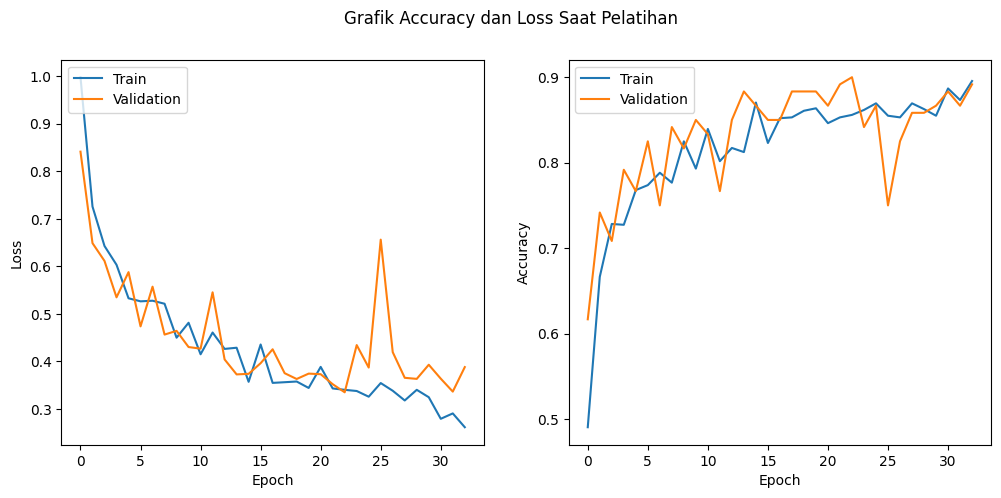

In [19]:
print("")
print(f"Val Accuracy: {(model_history.history['val_accuracy'])[-1]}")
print(f"Val Precision: {(model_history.history['val_precision'])[-1]}")
print(f"Val Recall: {(model_history.history['val_recall'])[-1]}")
print(f"Val F1 Score: {(model_history.history['val_f1_score'])[-1]}")

plt.figure(figsize=(12, 5))
plt.suptitle('Grafik Accuracy dan Loss Saat Pelatihan')

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
scores = model.evaluate(test_dataset)
print(f"Accuracy: {scores[1]}")
print(f"Precision: {scores[2]}")
print(f"Recall: {scores[3]}")
print(f"F1 Score: {scores[4]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.8462 - f1_score: 0.7601 - loss: 0.3230 - precision: 0.9091 - recall: 0.7692
Accuracy: 0.8461538553237915
Precision: 0.9090909361839294
Recall: 0.7692307829856873
F1 Score: 0.760073184967041


In [21]:
EXPORT_DIR = "/content/drive/MyDrive/Capstone/Models/20_Nov_2nd"
tf.saved_model.save(model, EXPORT_DIR)

In [2]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [3]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    --signature_name=serving_default \
    --saved_model_tags=serve \
    /content/drive/MyDrive/Capstone/Models/20_Nov_2nd \
    /content/drive/MyDrive/Capstone/JS_Models/20_Nov_2nd_TFJS

2024-11-20 10:15:12.950038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732097712.985607    3886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732097712.996164    3886 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 10:15:13.030239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-1